In [2]:
# If in colab, clone the repo and install the dependencies
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/GabrielDWu/piecewise-constant-objectives.git
    import sys
    sys.path.insert(0,'piecewise-constant-objectives')

    #install all packages in the install_requires of piecewise-constant-objectives (that aren't already in Colab)
    %pip install blobfile

    import os
    os.environ["BLOBFILE_FORCE_GOOGLE_ANONYMOUS_AUTH"] = "1"

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import piecewise_constant_objectives as pco
import json
import blobfile as bf
import itertools
from tqdm import tqdm

## Methods for visualizing results

In [2]:
def run_model_grid(ns, ds, objectives={"gmhp": {"num_steps": 250, "C_gmhp": 10000}, "ss": {"num_steps": 500}, "hook": {"num_steps": 500, "alpha_hook": 1}}):
    """
    Generates a dictionary all_losses[n][d][objective], and final_accs[n][d][objective]
    """
    all_losses = {n: {d: {} for d in ds} for n in ns}
    final_accs = {n: {d: {} for d in ds} for n in ns}

    for n, d, (objective, params) in tqdm(list(itertools.product(ns, ds, objectives.items())), desc="run_model_grid"):
        rnn = pco.RNN(hidden_size=d, seq_len=n, load_from_zoo=True)
        losses = pco.train_model(rnn, objective=objective, track=["acc"], **params, show_progress=False)
        all_losses[n][d][objective] = losses
        final_accs[n][d][objective] = losses["acc"][-1]
        print(f"n={n}, d={d}, objective={objective}, final acc={final_accs[n][d][objective]}; Δ(acc)={losses['acc'][-1] - losses['acc'][0]}")

    return all_losses, final_accs

def print_accuracy_table(ns, ds, final_accs):
    """
    Prints a table with columns of n, d, initial accuracy, and accuracy differential from each method.
    Also generates a bar plot comparing the accuracy differentials across methods.
    
    Args:
        ns: List of sequence lengths
        ds: List of hidden sizes
        final_accs: Dictionary of final accuracies indexed by n, d, and objective
    """
    print(f"{'n':^5}|{'d':^5}|{'Initial Acc':^12}|{'GMHP Diff':^12}|{'SS Diff':^12}|{'Hook Diff':^12}")
    print("-" * 65)
    
    
    # Store the data for plotting
    all_nd_labels = []
    gmhp_diffs = []
    ss_diffs = []
    hook_diffs = []
    
    for n in ns:
        for d in ds:
            # Create a new RNN instance for initial accuracy calculation
            # It will automatically load it onto the cuda if available.
            rnn = pco.RNN(hidden_size=d, seq_len=n, load_from_zoo=True)
            
            # Calculate initial accuracy using sampling_accuracy
            initial_acc = pco.sampling_accuracy(rnn, n_test=2**24).item()
            
            # Calculate accuracy differentials for each method
            gmhp_diff = final_accs[n][d]["gmhp"] - initial_acc
            ss_diff = final_accs[n][d]["ss"] - initial_acc
            hook_diff = final_accs[n][d]["hook"] - initial_acc
            
            # Store the data for plotting
            all_nd_labels.append(f"({n},{d})")
            gmhp_diffs.append(gmhp_diff)
            ss_diffs.append(ss_diff)
            hook_diffs.append(hook_diff)
            
            # Print the row
            print(f"{n:^5}|{d:^5}|{initial_acc:^12.4f}|{gmhp_diff:^12.4f}|{ss_diff:^12.4f}|{hook_diff:^12.4f}")
    
    # Create a bar plot for the accuracy differentials
    plt.figure(figsize=(15, 4))
    
    # Set up the x-axis positions for the grouped bars
    x = np.arange(len(all_nd_labels))
    width = 0.25  # Width of the bars
    
    # Create the bars for each method
    plt.bar(x - width, gmhp_diffs, width, label='GMHP', color='#1f77b4')
    plt.bar(x, ss_diffs, width, label='SS', color='#ff7f0e')
    plt.bar(x + width, hook_diffs, width, label='Hook', color='#2ca02c')
    
    # Set the y-axis limit
    y_limit = -0.07
    plt.ylim(bottom=y_limit)
    
    # Add value labels for hook_diff bars that are cut off by the y-axis limit
    for i, value in enumerate(hook_diffs):
        if value < y_limit:
            plt.text(x[i] + width, y_limit + 0.025, f"{value:.2g}".replace("-","—"), ha='center', va='top', fontsize=8, rotation=90)
    
    # Add value labels for ss_diff bars that are cut off by the y-axis limit
    for i, value in enumerate(ss_diffs):
        if value < y_limit:
            plt.text(x[i], y_limit + 0.025, f"{value:.2g}".replace("-","—"), ha='center', va='top', fontsize=8, rotation=90)

    # Add labels, title, and legend
    plt.xlabel('RNN size (n, d)')
    plt.ylabel('Accuracy Improvement')
    plt.xticks(x, all_nd_labels)
    plt.legend()
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

def plot_objective_grid(all_losses, n, d):
    """
    Creates a 2x2 grid of subplots showing:
    - NW: Accuracy curves for all objectives (normalized by gradient steps)
    - NE: SS objective loss curve
    - SE: HH (Hook) objective loss curve
    - SW: GMHP objective loss curve
    
    Args:
        all_losses: Dictionary of losses indexed by n, d, and objective
        n: Sequence length
        d: Hidden size
    """
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle(f'n={n}, d={d}', fontsize=16)
    
    # Define colors for each objective (matching print_accuracy_table)
    colors = {
        'gmhp': '#1f77b4',  # blue
        'ss': '#ff7f0e',    # orange
        'hook': '#2ca02c'   # green
    }
    
    # Extract losses for the specified n and d
    losses = all_losses[n][d]
    
    # Get the number of steps for each objective
    gmhp_steps = len(losses['gmhp']['acc'])
    ss_steps = len(losses['ss']['acc'])
    hook_steps = len(losses['hook']['acc'])
    
    # NW subplot - Accuracy for all objectives (with normalized steps)
    ax_acc = axes[0, 0]
    
    # Create normalized x-axes for each accuracy curve
    gmhp_x = np.linspace(0, 1, gmhp_steps)
    ss_x = np.linspace(0, 1, ss_steps)
    hook_x = np.linspace(0, 1, hook_steps)
    
    # Plot accuracy curves
    ax_acc.plot(gmhp_x, losses['gmhp']['acc'], label='GMHP', color=colors['gmhp'], linewidth=2)
    ax_acc.plot(ss_x, losses['ss']['acc'], label='SS', color=colors['ss'], linewidth=2)
    ax_acc.plot(hook_x, losses['hook']['acc'], label='Hook', color=colors['hook'], linewidth=2)
    
    ax_acc.set_title('Accuracy')
    ax_acc.set_xlabel('Normalized Gradient Steps')
    ax_acc.grid(True, alpha=0.3)
    ax_acc.legend()
    
    # NE subplot - SS objective
    ax_ss = axes[0, 1]
    if 'ss' in losses['ss']:  # The loss might be named 'ss'
        ax_ss.plot(losses['ss']['ss'], color=colors['ss'], linewidth=2)
    else:  # If there's no specific 'ss' loss, use the objective
        for key in losses['ss'].keys():
            if key != 'acc':  # Plot the non-accuracy loss
                ax_ss.plot(losses['ss'][key], color=colors['ss'], linewidth=2)
                break
    
    ax_ss.set_title('SS Objective')
    ax_ss.set_xlabel('Gradient Steps')
    ax_ss.grid(True, alpha=0.3)
    
    # SE subplot - Hook objective
    ax_hook = axes[1, 1]
    if 'hook' in losses['hook']:  # The loss might be named 'hook'
        ax_hook.plot(losses['hook']['hook'], color=colors['hook'], linewidth=2)
    else:  # If there's no specific 'hook' loss, use the objective
        for key in losses['hook'].keys():
            if key != 'acc':  # Plot the non-accuracy loss
                ax_hook.plot(losses['hook'][key], color=colors['hook'], linewidth=2)
                break
    
    ax_hook.set_title('Hook Objective')
    ax_hook.set_xlabel('Gradient Steps')
    ax_hook.grid(True, alpha=0.3)
    
    # SW subplot - GMHP objective
    ax_gmhp = axes[1, 0]
    if 'gmhp' in losses['gmhp']:  # The loss might be named 'gmhp'
        ax_gmhp.plot(losses['gmhp']['gmhp'], color=colors['gmhp'], linewidth=2)
    else:  # If there's no specific 'gmhp' loss, use the objective
        for key in losses['gmhp'].keys():
            if key != 'acc':  # Plot the non-accuracy loss
                ax_gmhp.plot(losses['gmhp'][key], color=colors['gmhp'], linewidth=2)
                break
    
    ax_gmhp.set_title('GMHP Objective')
    ax_gmhp.set_xlabel('Gradient Steps')
    ax_gmhp.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    plt.show()

## Run main experiment
Here, we train each model on each of the objectives (GMHP, SS, Hook)

In [ ]:
ns = [4, 5, 6, 8]
ds = [3, 4, 5, 6]
all_losses, final_accs = run_model_grid(ns, ds)

Alternatively, you can skip the above cell and load the stored results:

In [5]:
def convert_keys_to_int(d):
    if isinstance(d, dict): return {int(k) if k.isdigit() else k: convert_keys_to_int(v) for k, v in d.items()}
    else: return d

with bf.BlobFile(f"gs://arc-ml-public/gabe-thesis/all_losses_and_accs.json", "r") as f:
    losses_and_accs = convert_keys_to_int(json.load(f))

all_losses = losses_and_accs["all_losses"]
final_accs = losses_and_accs["final_accs"]

ns = sorted(list(all_losses.keys()))
ds = sorted(list(all_losses[ns[0]].keys()))

The next cells visualize the results and plot loss curves.

  n  |  d  |Initial Acc | GMHP Diff  |  SS Diff   | Hook Diff  
-----------------------------------------------------------------
  4  |  3  |   0.4329   |   0.0196   |   0.0073   |  -0.0008   
  4  |  4  |   0.6021   |   0.0186   |   0.0276   |   0.0186   
  4  |  5  |   0.7457   |  -0.0008   |   0.0162   |  -0.0027   
  4  |  6  |   0.8648   |  -0.0068   |   0.0081   |   0.0036   
  5  |  3  |   0.3757   |   0.0084   |   0.0107   |  -0.0284   
  5  |  4  |   0.4285   |   0.0332   |   0.0403   |  -0.0154   
  5  |  5  |   0.5421   |  -0.0307   |   0.0018   |  -0.0179   
  5  |  6  |   0.7026   |  -0.0188   |   0.0364   |   0.0123   
  6  |  3  |   0.3402   |   0.0032   |  -0.0037   |  -0.0374   
  6  |  4  |   0.3939   |   0.0068   |   0.0170   |  -0.0422   
  6  |  5  |   0.4501   |   0.0247   |   0.0373   |   0.0028   
  6  |  6  |   0.4844   |   0.0126   |   0.0368   |  -0.0124   
  8  |  3  |   0.2855   |  -0.0106   |  -0.0190   |  -0.0529   
  8  |  4  |   0.3458   |   0.0109   |

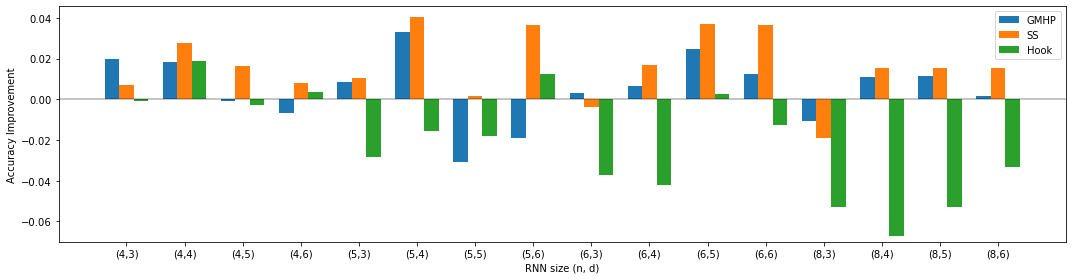

In [ ]:
# Might give slightly different figures than in the paper due to sampling noise in Initial Acc.
# This will run faster if cuda is available.
print_accuracy_table(ns, ds, final_accs)

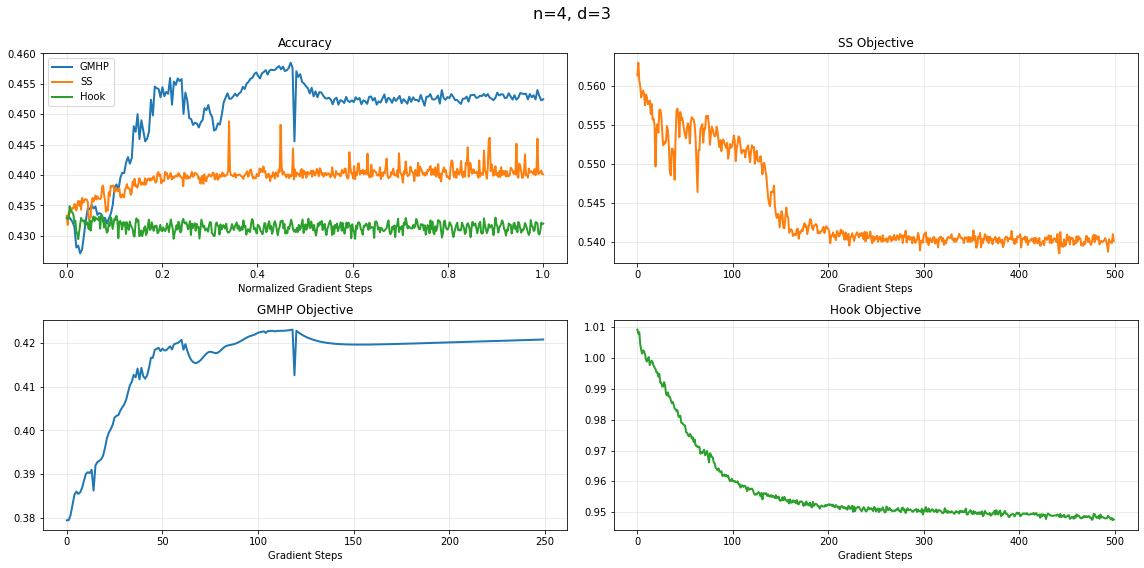

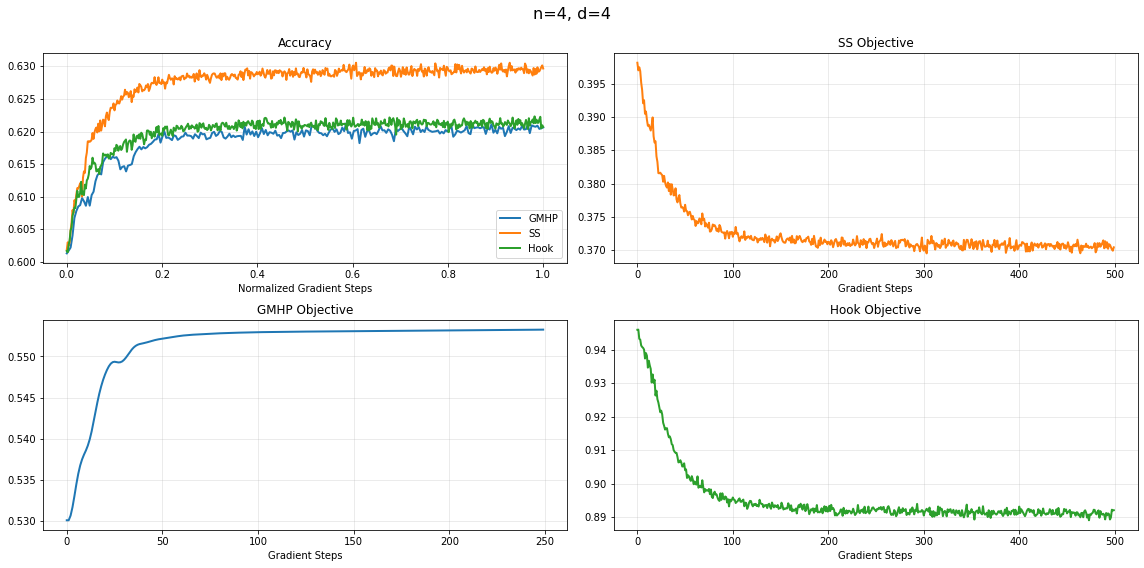

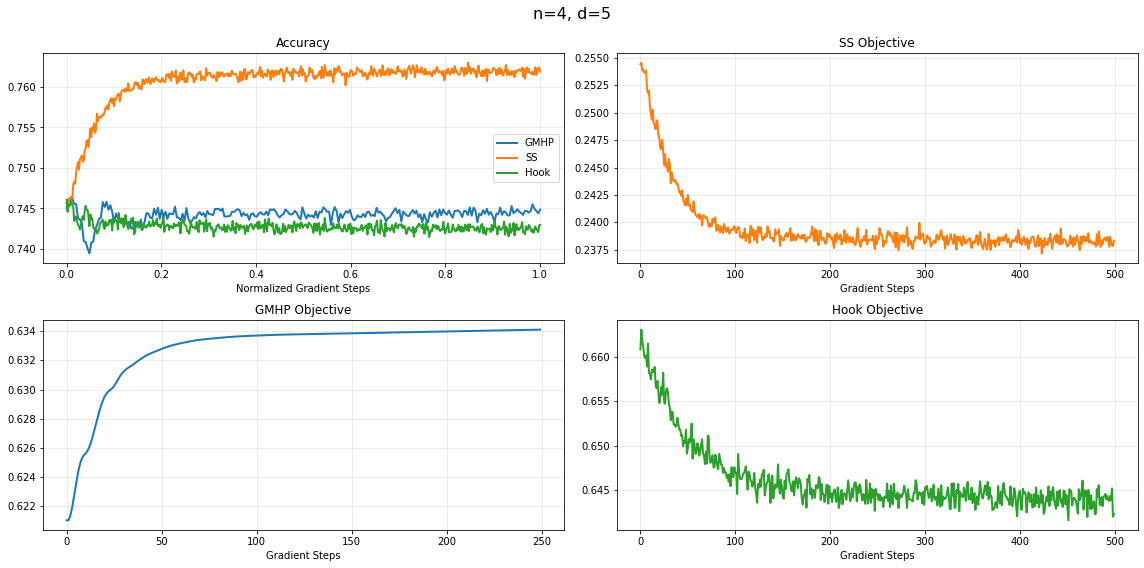

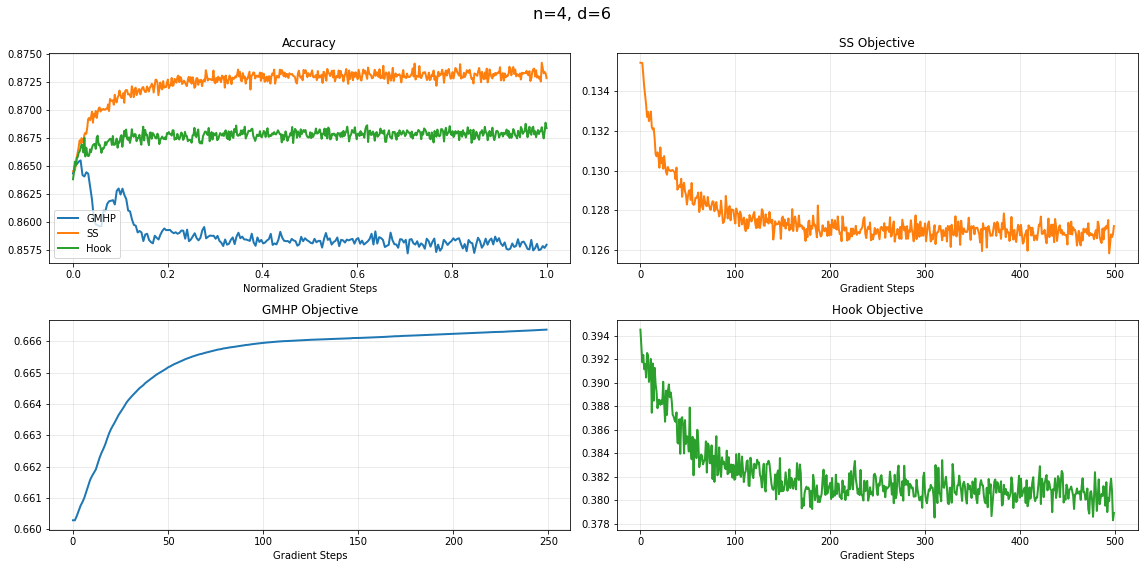

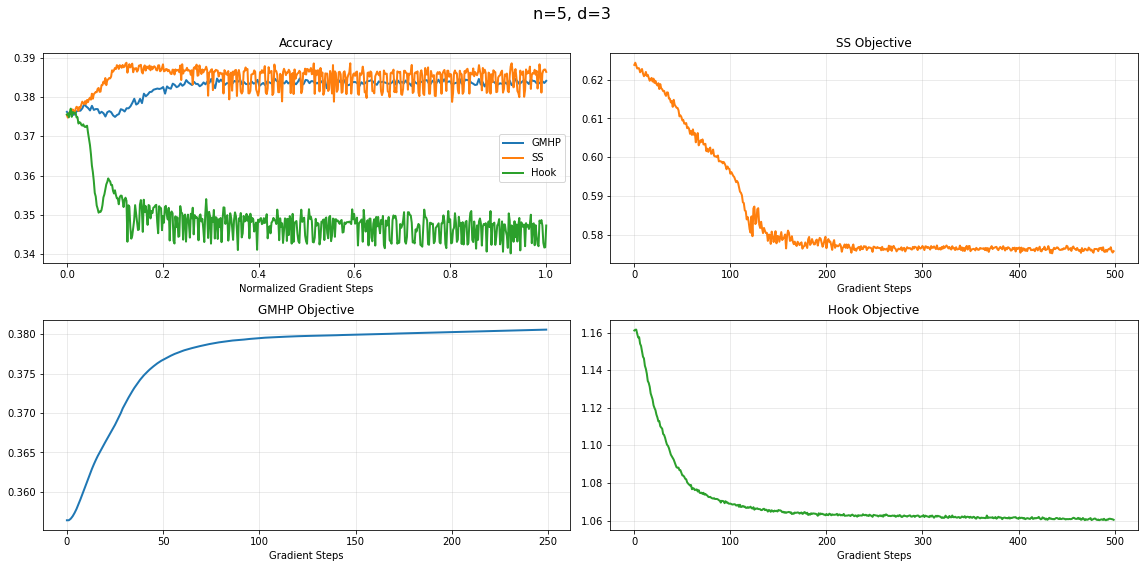

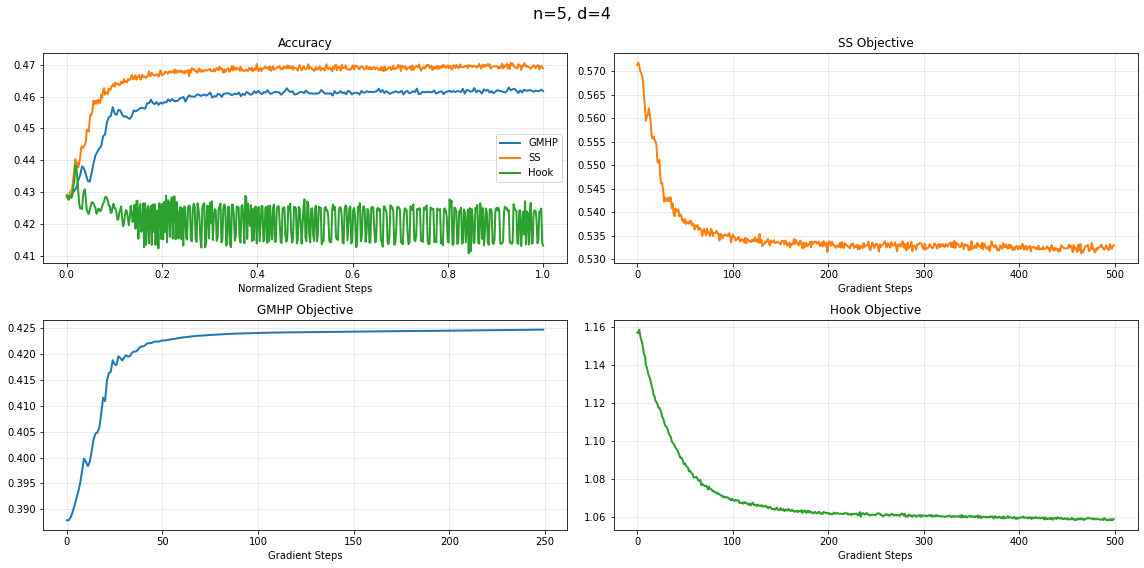

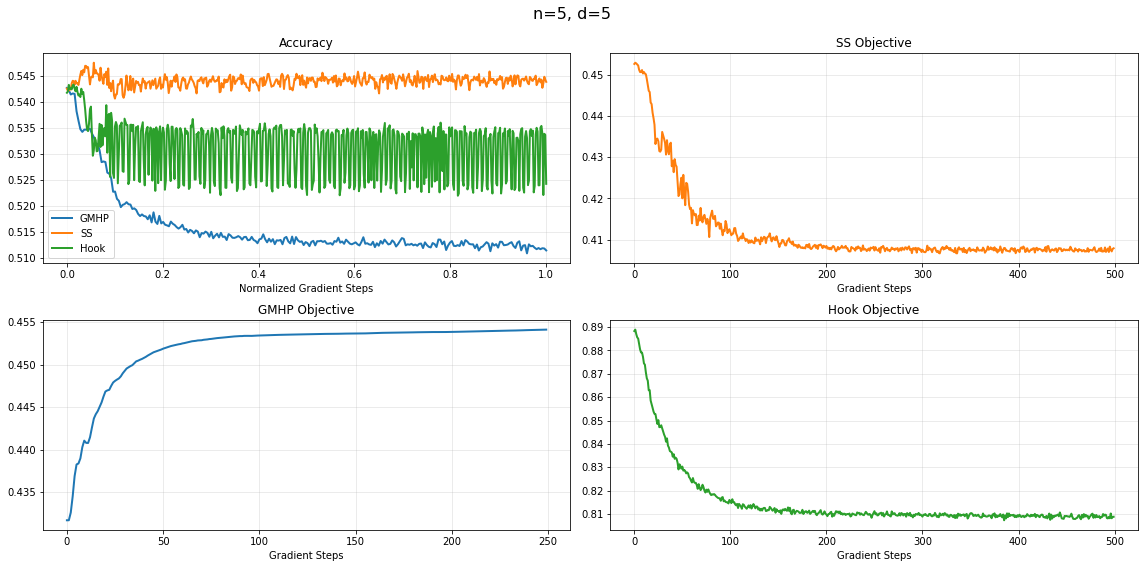

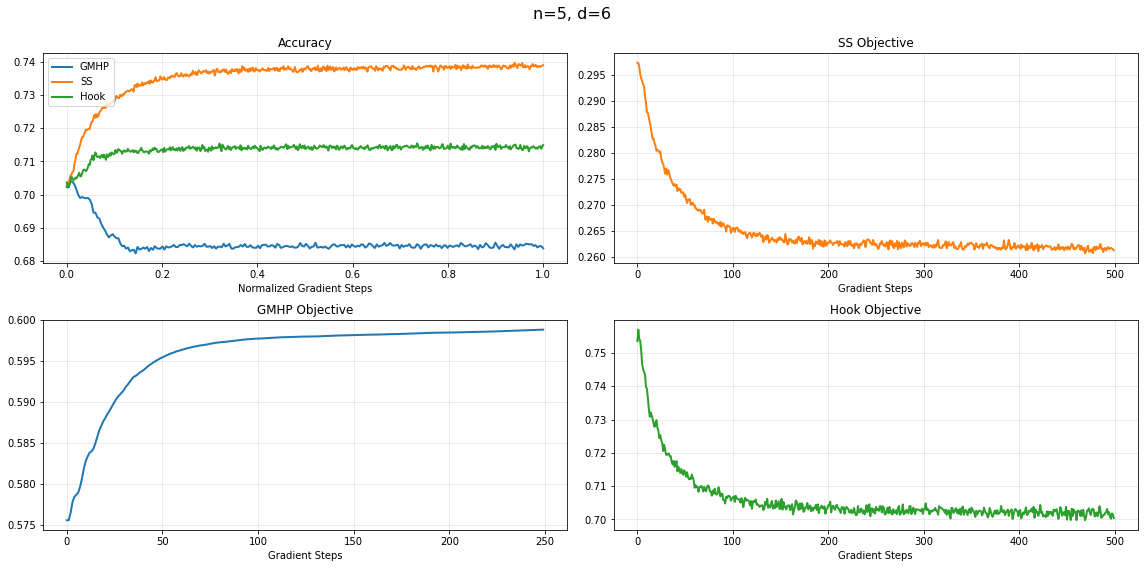

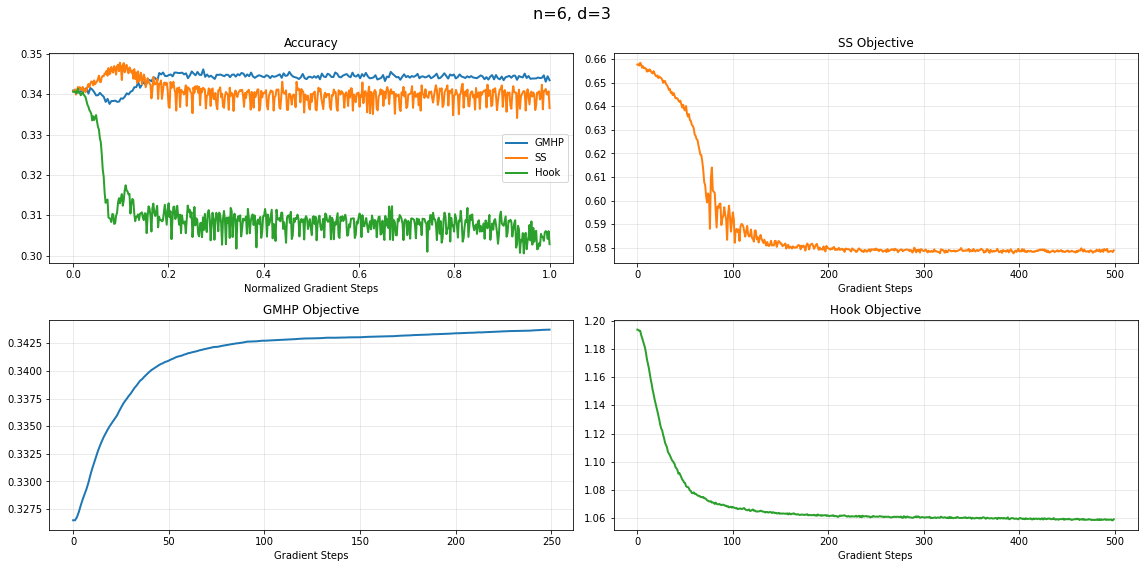

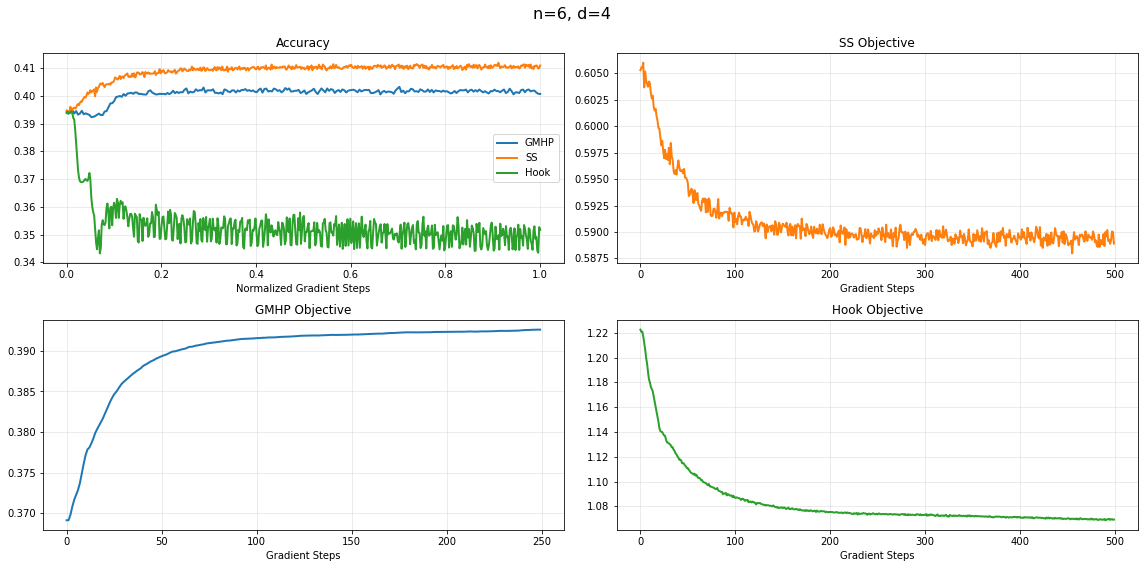

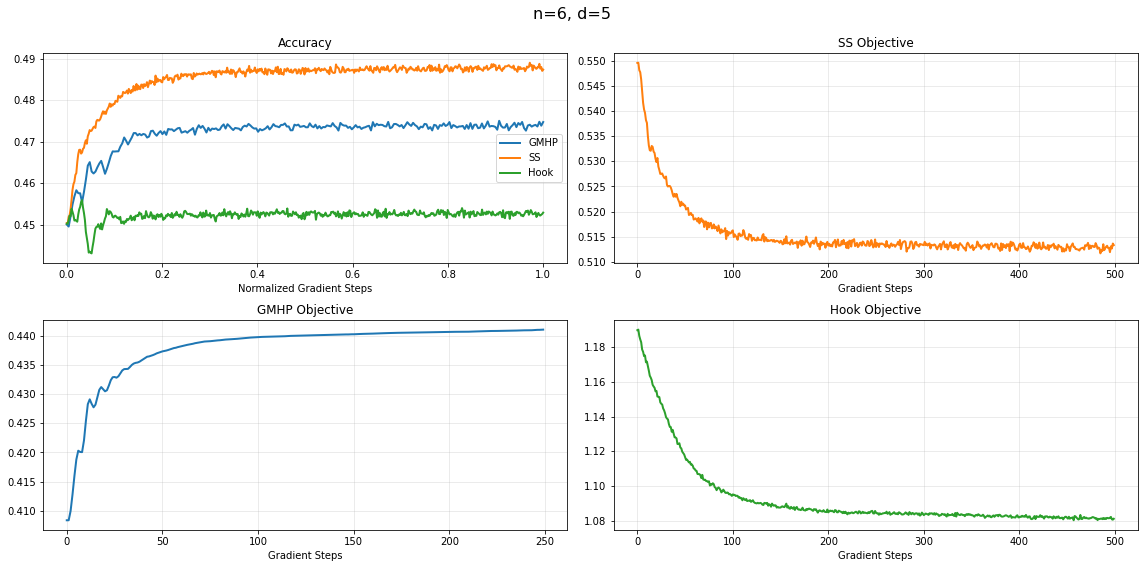

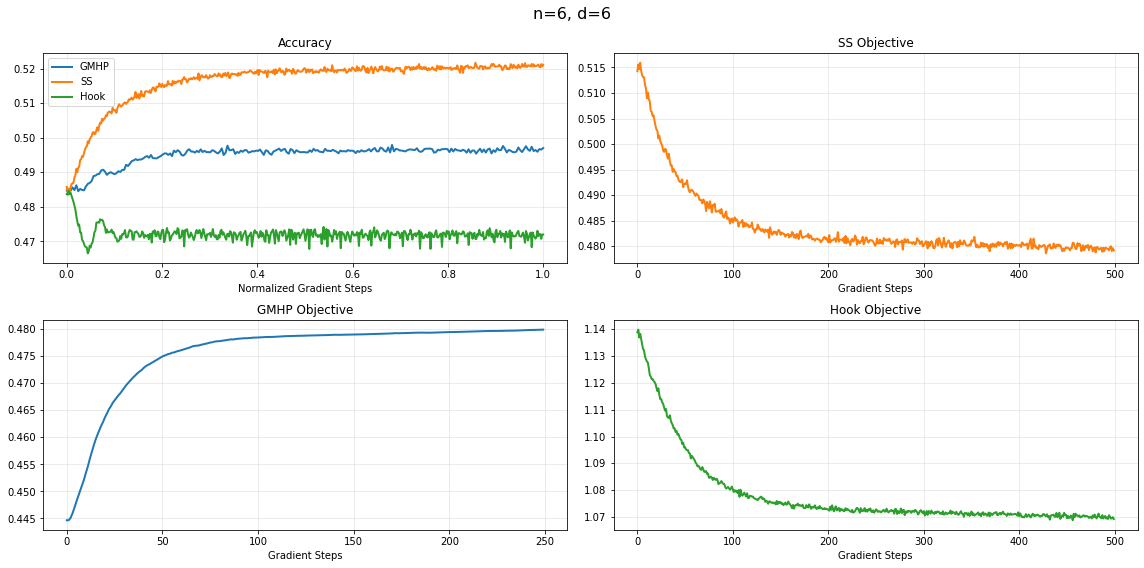

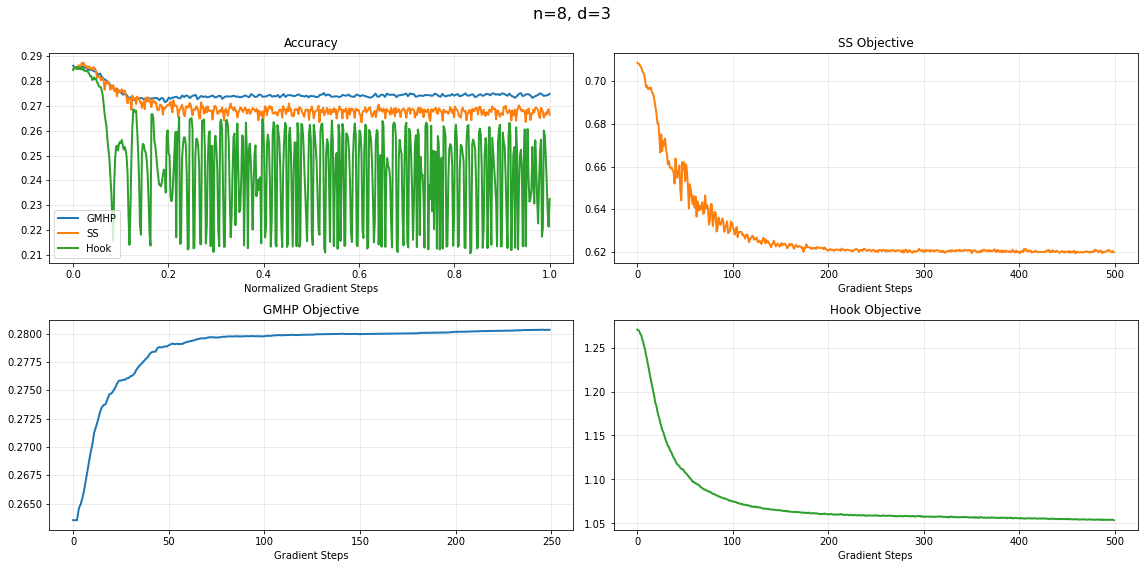

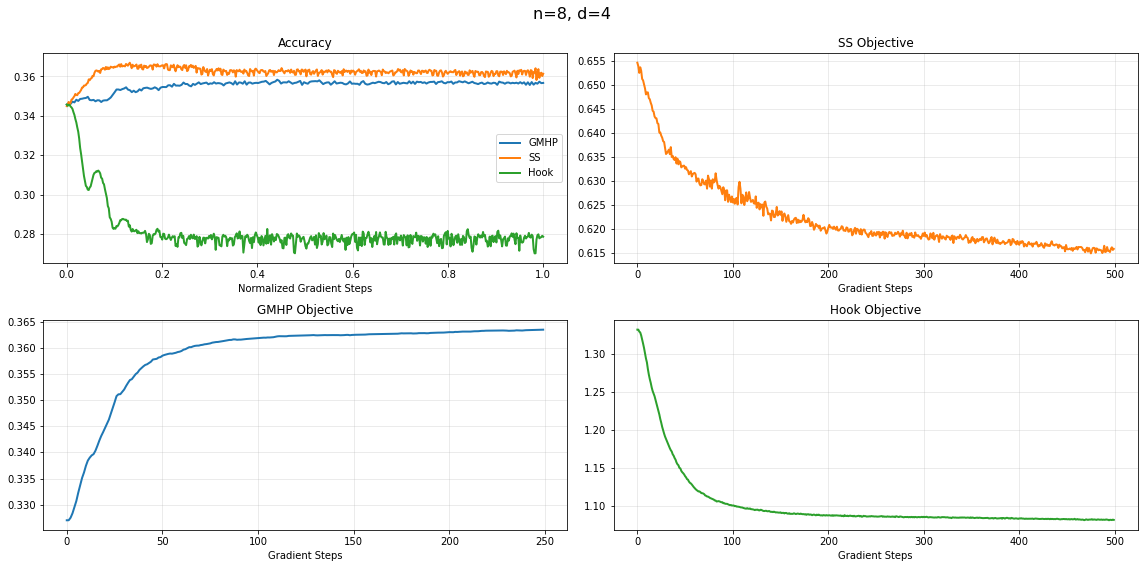

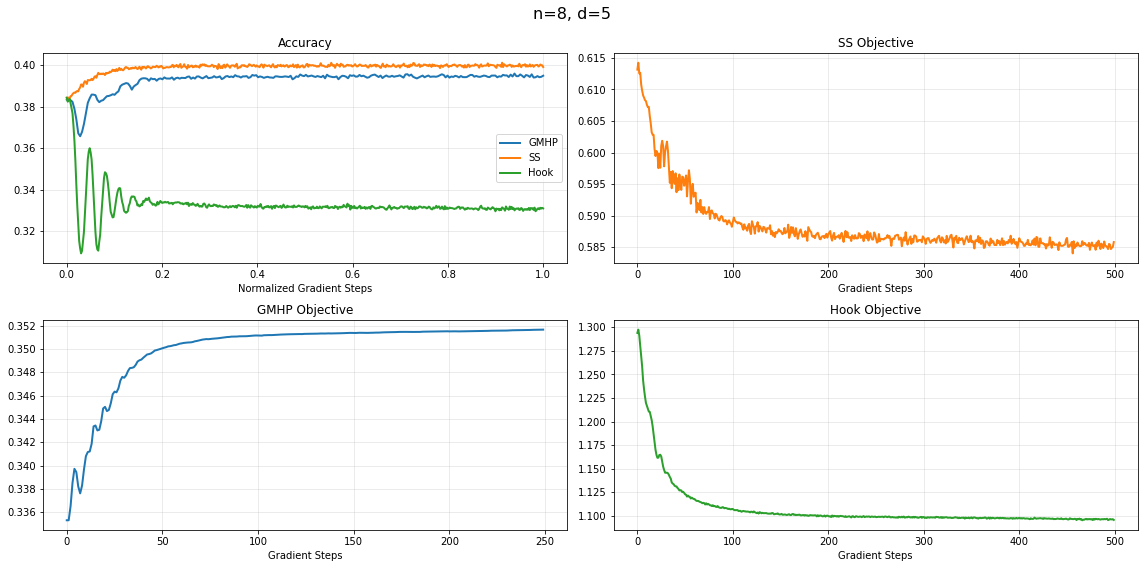

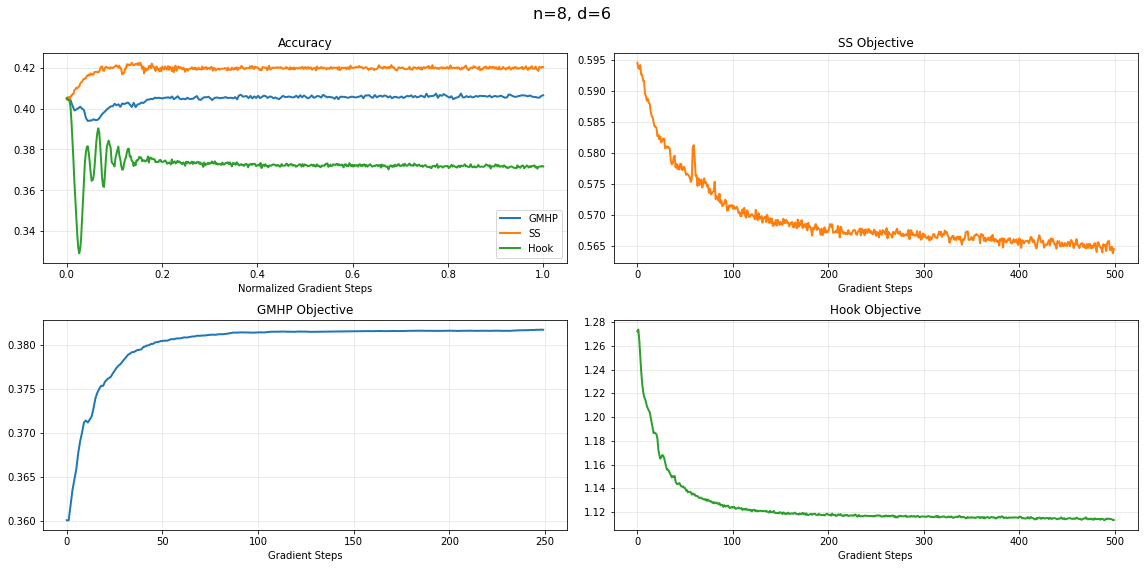

In [7]:
for n in [4, 5, 6, 8]:
    for d in [3, 4, 5, 6]:
        plot_objective_grid(all_losses, n, d)

Finally, we can also optimize a $n=3$ model against Girard Accuracy:

100%|██████████| 500/500 [13:07<00:00,  1.57s/it]


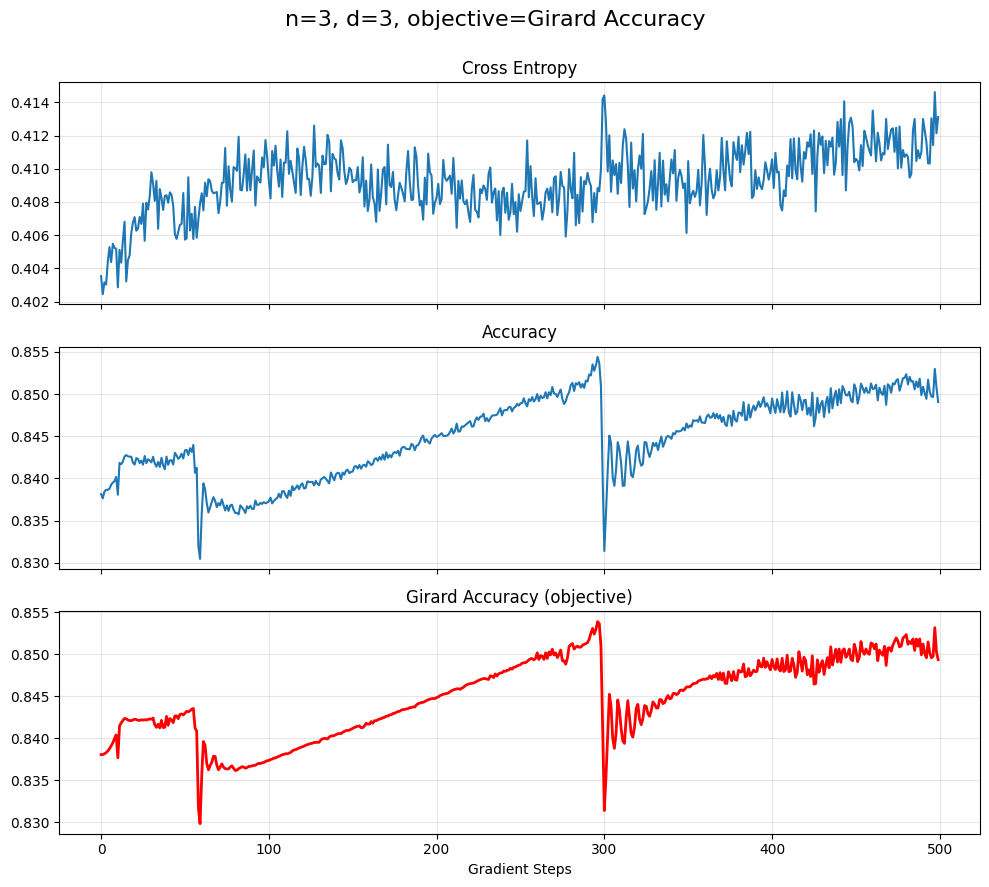

In [4]:
# Note: for some strange reason, this training run goes slightly differently depending on your machine.
# Even though the algorithm is deterministic, do not expect the exact same results as the paper.
rnn = pco.RNN(hidden_size=3, seq_len=3, load_from_zoo=True).to("cpu") # It's faster to run on CPU
losses = pco.train_model(rnn, objective="girard", num_steps=500, lr_base=0.005, lr_decay_min_mult=1, track=["ce", "acc"])

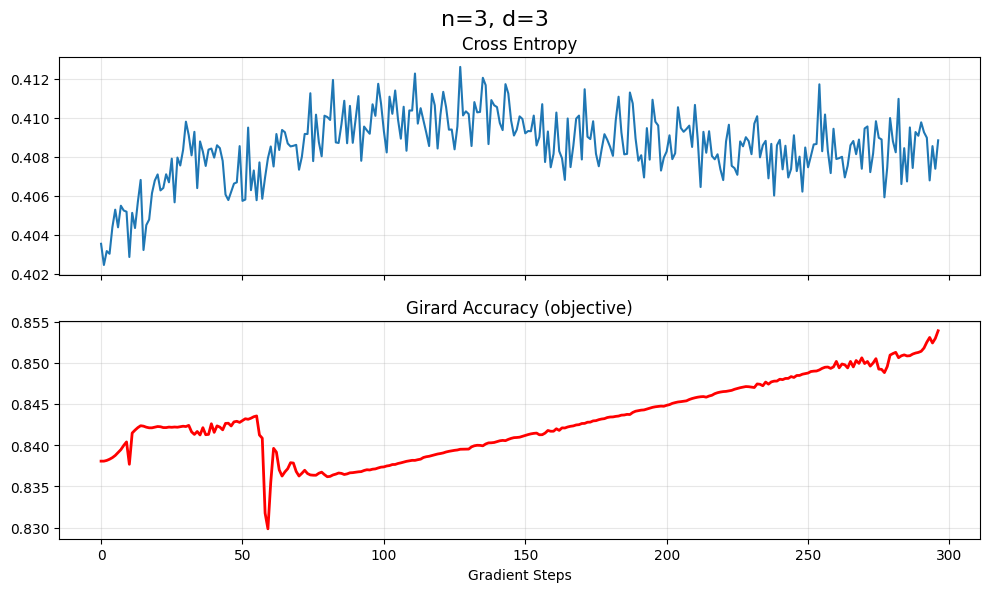

In [5]:
losses_short = {}
for key in losses.keys():
    if key != "acc":
        losses_short[key] = losses[key][:297]

pco.plot_losses(losses_short, "girard", title="n=3, d=3") # Figure in the paper.